In [141]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation as mad
import time

Useful function for the plot

In [142]:
def display_band( X, par,epsi=0.001,col='k'):
    x1 = np.min(X[0, :])
    x2 = np.max(X[0, :])
    y1 = np.min(X[1, :])
    y2 = np.max(X[1, :])

    # extend the line for the k# of its lenght 
    k = 0.01
    dx = x2-x1
    dy = y2-y1
    l = np.sqrt(dx**2+dy**2)
    x1 = x1 - k*l
    x2 = x2 + k*l
    y1 = y1 - k*l
    y2 = y2 + k*l
    ##
    if np.abs(par[1])<2e-2 :
        #disp('vertical line')
        a = np.vstack([-(par[1]*y1 + par[2])/par[0], y1])
        b = np.vstack([-(par[1]*y2 + par[2])/par[0], y2])
    else:
        a = np.vstack([x1, -(par[0]*x1 + par[2])/par[1]])
        b = np.vstack([x2, -(par[0]*x2 + par[2])/par[1]])

    if np.abs(par[0])<1e-5:
        v = np.array([0,1]) 
    else:    
        v = np.array([1, par[1]/par[0]])# direction perpendicular to the line;

    v = v / np.sqrt(np.sum(v**2));
    # corners of the bands
    v = v[:, np.newaxis]
    a1 = a - epsi * v;
    a2 = a + epsi * v;
    b1 = b - epsi * v;
    b2 = b + epsi * v;

    px = np.array([a1[0], b1[0], b2[0], a2[0]]).squeeze()
    py = np.array([a1[1], b1[1], b2[1], a2[1]]).squeeze()
    plt.tricontourf(px,py,np.ones_like(px), colors=col,alpha=0.5)
    plt.gca().set_aspect('equal')

Function that computes the residual between points and a line

In [143]:
def res_line(X, M):
    if len(M.shape) > 1:
        num_lines = M.shape[1]
    else:
        num_lines = 1

    if num_lines == 1:
        d = np.abs(M[0] * X[0, :] + M[1] * X[1, :] + M[2])
    else:
        n = X.shape[1]
        d = np.zeros((n, num_lines))
        for i in range(num_lines):
            d[:, i] = np.abs(M[0, i] * X[0, :] + M[1, i] * X[1, :] + M[2, i])
    
    return d


Implement the following function, that computes the solution of the overdetermined system

$$\underset{A}{\text{argmin}} \| A\mathbf x - \mathbf y\|_2^2$$

via OLS and DLT

The input $P=[[x_1, y_1], \dots,[x_N,y_N]]$ collects the points where the line $y = mx+q$ should pass through


In [144]:
def fit_line_ols(P):
    # design matrix
    A = np.vstack([P[:, 0], np.ones(P.shape[0])]).T
    # vector of responses 
    y = P[:, 1] 

    # straight line coefficient
    theta = np.linalg.inv(A.T @ A) @ A.T @ y

    residuals = y - A @ theta;
    residual_error = np.sum(residuals ** 2)
    return theta, residuals, residual_error

In [145]:
def fit_line_dlt(P):
    # Preconditioning
    mean_X = np.mean(P.T[:, 0])
    std_X = np.std(P.T[:, 0])
    mean_Y = np.mean(P.T[:, 1])
    std_Y = np.std(P.T[:, 1])
    
    X = (P.T[:, 0] - mean_X) / std_X
    Y = (P.T[:, 1] - mean_Y) / std_Y
    ONES = np.ones_like(X)
    
    # design matrix
    A = np.hstack([X[:, np.newaxis], Y[:, np.newaxis], ONES[:, np.newaxis]])
    
    # SVD
    U, S, V = np.linalg.svd(A)
    
    # vector of responses 
    y = P.T[:, 1]
    
    theta = V.T[: , -1]
    
    # Reverting preconditioning
    a, b, c = theta
    a_orig = a / std_X
    b_orig = b / std_Y
    c_orig = c - (a * mean_X / std_X) - (b * mean_Y / std_Y)
    
    # Normalizing
    norm = np.sqrt(a_orig**2 + b_orig**2)
    theta_orig = [a_orig / norm, b_orig / norm, c_orig / norm]

    residuals = res_line(P, theta) 
    residual_error = np.sum(residuals ** 2)
    
    
    return np.array(theta_orig), residuals, residual_error

Robust Fitting Methods
----------------------
Implements the following methods:

In [146]:
def simpleRANSAC(X, eps, cardmss = 2):
    """
    SIMPLERANSAC - Robust fit with the LMEDS algorithm
    X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
    """
    # number of samples in the dataset
    n = X.shape[1] 
    # Desired probability of success
    alpha = 0.99 

    # Pessimistic estimate of inliers fraction
    f = 0.5

    # set maximum number of iterations
    MaxIterations = 100

    # set maximum consensus reached
    maxscore = - np.inf
    
    for i in range(MaxIterations):
        
        # Generate cardmss random indices in the range 0..n-1
        mss = X[:, np.random.choice(n, cardmss, replace=False)]
        
        # Fit model to this minimal sample set.
        theta = fit_line_dlt(mss)[0]

        # Evaluate distances between points and model
        sqres = res_line(X, theta)

        # identify inliers: consensus set
        inliers = np.where(sqres < eps)[0]

        # assess consensus (the number of inliers)
        score = len(inliers)

        # replace maxscore, bestinliers and bestmodel if needed
        if score > maxscore:
            maxscore = score
            bestinliers = inliers
            bestmodel = theta

    return bestmodel, bestinliers

In [147]:
def simpleMSAC(X, eps, cardmss = 2):
  n = X.shape[1]
  alpha = 0.99 # Desired probability of success
  f = 0.5 # Pessimistic estimate of inliers fraction

  # set maximum number of iterations
  # MaxIterations = 

  # set maximum consensus reached
  # mincost = 

  for i in range(MaxIterations):
    # Generate cardmss random indices in the range 0..n-1
    # mss = 

    # Fit model to this minimal sample set.
    # theta =

    # Evaluate distances between points and model
    # sqres =  

    # identify inliers: consensus set
    inliers = np.where(sqres <= eps)[0]

    # Compute MSAC score
    # cost = 

    # replace mincost, bestinliers and bestmodel if needed
    #  mincost = 
    #  bestinliers = 
    #  bestmodel = 

  return bestmodel, bestinliers

In [148]:
def simpleLMEDS(X, cardmss = 2):
  n = X.shape[1]
  alpha = 0.99 # Desired probability of success
  f = 0.5 # Pessimistic estimate of inliers fraction

  # set maximum number of iterations
  # MaxIterations = 

  # set maximum consensus reached
  # mincost =

  for i in range(MaxIterations):
    # Generate cardmss random indicies in the range 0..n-1
    # mss = 

    # Fit model to this minimal sample set.
    # theta = 

    # Evaluate distances between points and model
    # sqres =  

    # Compute LMS score
    # cost =  

    # define inliner threshold (does make sense only when the model provides a good fit)
    # compute the standard deviation of distances (you can use MAD)
    # scale = 

    # instead of 3-sigma rule, we do 2.5-sigma rule. sqres is already squares
    inliers = np.where(sqres < 2.5*scale)[0]

    # replace mincost, bestinliers and bestmodel if needed
    # mincost = 
    # bestinliers = 
    # bestmodel = 

  return bestmodel, bestinliers


Fitting over noisy data
-----------------------
Set the parameters and generate the dataset

In [149]:
cardmss = 2          # minimum number of points required to fit a model

# plotting params
BAND_WIDTH = 0.05
BAND_COLOR = 'b'

# create noisy dataset
x = np.linspace(0,1,100)
y = 1.5 * x + 1;
X = np.vstack((x, y))
sigma = 0.01;
X = X + sigma * np.random.normal(size=X.shape)

Least square fit to noisy data

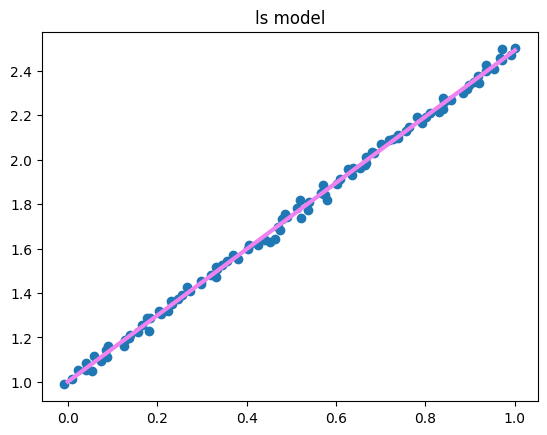

In [150]:
model_OLS = fit_line_ols(X.T)[0]
plt.figure()
plt.scatter(X[0,:], X[1,:])
plt.plot([0, 1], [model_OLS[1], model_OLS[0] + model_OLS[1]], 'violet', linewidth=3)
plt.title('ls model')
plt.show()

Least square fit via DLT (different model parametrization)

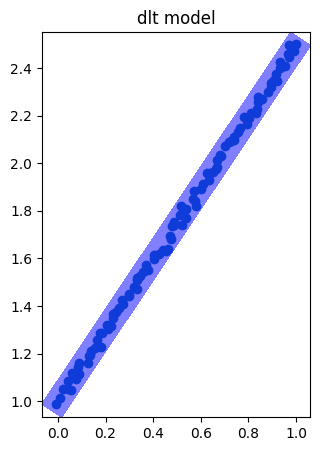

In [151]:
model_DLT = fit_line_dlt(X)[0]
plt.figure(figsize = (15,5))
plt.scatter(X[0,:], X[1,:])
display_band(X, model_DLT, BAND_WIDTH , BAND_COLOR)
plt.title('dlt model')
plt.show()

Add a single outlier to the data, obtaining a new dataset $X_{out}$

In [152]:
X_out = X.copy()
X_out = np.hstack((X_out, np.array([[1],[1]])))

Least square fit to noisy data with a single outlier

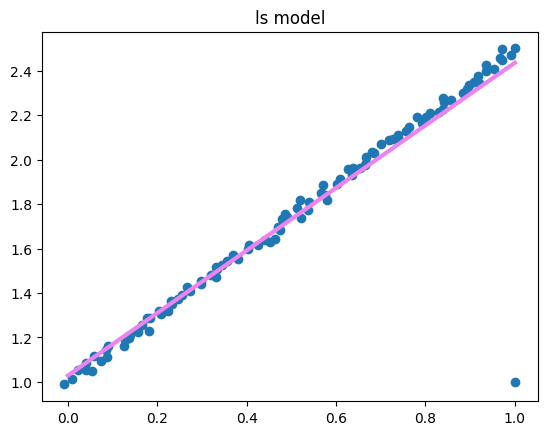

In [153]:
model_OLS = fit_line_ols(X_out.T)[0]
plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
plt.plot([0, 1], [model_OLS[1], model_OLS[0] + model_OLS[1]], 'violet', linewidth=3)
plt.title('ls model')
plt.show()

Least square fit via DLT to noisy data with a single outlier

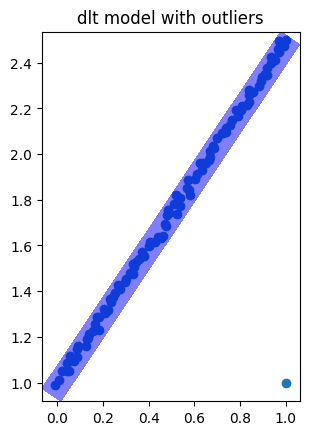

In [154]:
model_DLT = fit_line_dlt(X_out)[0]

plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
display_band(X_out, model_DLT, BAND_WIDTH , BAND_COLOR)
plt.title('dlt model with outliers')
plt.show()

Add many outliers to the noisy data

In [155]:
n_out = 50
# Add outliers betweeen 0.5 and 1 in x and 0.5 and 1.5 in y
x_new = np.random.rand(2,n_out)
x_new[0,:] = x_new[0,:]*0.5 + 0.5
x_new[1,:] = x_new[1,:]*0.5 + 1
X_out = np.hstack((X_out, x_new))

Least square fit

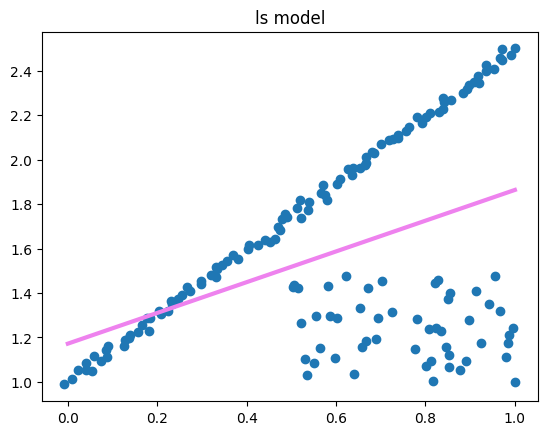

In [156]:
model_OLS = fit_line_ols(X_out.T)[0]

plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
plt.plot([0, 1], [model_OLS[1], model_OLS[0] + model_OLS[1]], 'violet', linewidth=3)
plt.title('ls model')
plt.show()

Least square via DLT

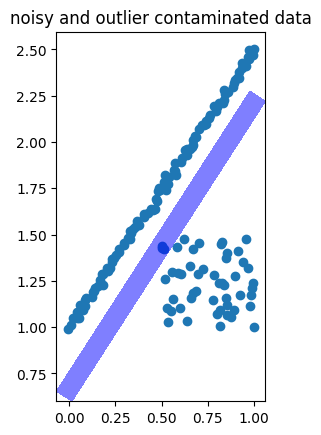

In [157]:
model_DLT = fit_line_dlt(X_out)[0]

plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
display_band(X_out, model_DLT, BAND_WIDTH , BAND_COLOR)
plt.title('noisy and outlier contaminated data')
plt.show()

Robust Fitting methods
----------------------
Use Ransac, M-Sac and L-Meds to perform fitting on data with many outliers

Ransac:


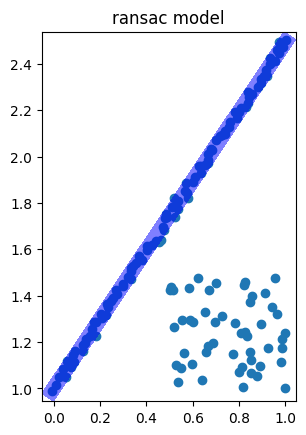

In [158]:
epsi = 3 * sigma # define inlier threshold

# invoke simpleRANSAC
bestmodel, bestinliers = simpleRANSAC(X_out, epsi, cardmss)

# refine model estimates
refinedModel = fit_line_dlt(X_out[:, bestinliers])[0]

plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
display_band(X_out, refinedModel, epsi, BAND_COLOR)
plt.title('ransac model')
plt.show()

M-Sac:

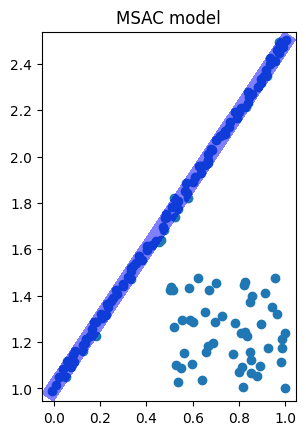

In [159]:
# bestmodel, bestinliers =  

# refine model estimates
# refinedModel = 

plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
display_band(X_out, refinedModel, epsi, BAND_COLOR)
plt.title('MSAC model')
plt.show()

L-Meds:

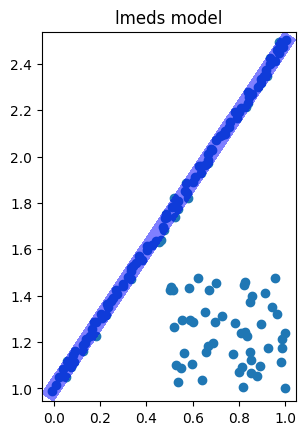

In [160]:
# invoke simpleLMEDS
# bestmodel, bestinliers = 

# refine model estimates
# refinedModel = 

plt.figure()
plt.scatter(X_out[0,:], X_out[1,:])
display_band(X_out, refinedModel, epsi, BAND_COLOR)
plt.title('lmeds model')
plt.show()
